In [1]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cpu')

In [2]:
import cv2

from yolort.utils import (
    cv2_imshow,
    get_image_from_url,
    read_image_to_tensor,
    update_module_state_from_ultralytics,
)

In [3]:
from yolort.utils.image_utils import plot_one_box, color_list
from yolort.v5 import load_yolov5_model, letterbox, non_max_suppression, scale_coords

## Prepare image and model weights to test

In [4]:
is_half = False

# img_path = "https://raw.githubusercontent.com/zhiqwang/yolov5-rt-stack/master/test/assets/zidane.jpg"
img_path = "https://gitee.com/zhiqwang/yolov5-rt-stack/raw/master/test/assets/zidane.jpg"
img_raw = get_image_from_url(img_path)

path_yolort_weight = 'yolov5s_r50_updated.pt'
path_ultralytics_weights = 'yolov5s.pt'

You can download the weight with following methods

```python
torch.hub.download_url_to_file(
    r'https://github.com/ultralytics/yolov5/releases/download/v5.0/yolov5s.pt',
    path_ultralytics_weights,
    progress=True,
)
```

In [5]:
# Preprocess
img = letterbox(img_raw, new_shape=(640, 640))[0]
img = read_image_to_tensor(img, is_half)
img = img.to(device)

## Load model as ultralytics and inference

In [6]:
conf = 0.25
iou = 0.45

model = load_yolov5_model(path_ultralytics_weights, autoshape=False, verbose=True)
model = model.to(device)
model.conf = conf  # confidence threshold (0-1)
model.iou = iou  # NMS IoU threshold (0-1)
model.classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
model.eval()

# Get actual anchors from ultralytics model
m = model.model[-1]  # get Detect() layer
anchor_grids = m.anchor_grid.view((3, -1)).cpu().tolist()  # get anchors

with torch.no_grad():
    ultralytics_dets = model(img[None])[0]
    ultralytics_dets = non_max_suppression(ultralytics_dets, conf, iou, agnostic=True)[0]


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  yolort.v5.models.common.Focus           [3, 32, 3]                    
  1                -1  1     18560  yolort.v5.models.common.Conv            [32, 64, 3, 2]                
  2                -1  1     18816  yolort.v5.models.common.C3              [64, 64, 1]                   
  3                -1  1     73984  yolort.v5.models.common.Conv            [64, 128, 3, 2]               
  4                -1  3    156928  yolort.v5.models.common.C3              [128, 128, 3]                 
  5                -1  1    295424  yolort.v5.models.common.Conv            [128, 256, 3, 2]              
  6                -1  3    625152  yolort.v5.models.common.C3              [256, 256, 3]                 
  7                -1  1   1180672  yolort.v5.models.common.Conv            [256, 512, 3, 2]              
  8                -1  1    656896  

In [7]:
# NOTE: the value of `anchor_grids` may chang if you are using the autoanchor mechanism
print(anchor_grids)

[[10.0, 13.0, 16.0, 30.0, 33.0, 23.0], [30.0, 61.0, 62.0, 45.0, 59.0, 119.0], [116.0, 90.0, 156.0, 198.0, 373.0, 326.0]]


In [8]:
print(f'Detection results with ultralytics:\n{ultralytics_dets}')

Detection results with ultralytics:
tensor([[3.74815e+02, 3.34818e+01, 5.74179e+02, 3.66425e+02, 8.77349e-01, 0.00000e+00],
        [2.16808e+02, 2.28983e+02, 2.58949e+02, 3.69584e+02, 6.60622e-01, 2.70000e+01],
        [5.69029e+01, 1.10171e+02, 5.46977e+02, 3.67121e+02, 5.93856e-01, 0.00000e+00],
        [4.93081e+02, 1.64193e+02, 5.13974e+02, 2.22168e+02, 2.87125e-01, 2.70000e+01]])


## Updating model weights from ultralytics to yolort

In [9]:
model = update_module_state_from_ultralytics(
    checkpoint_path=path_ultralytics_weights,
    arch='yolov5s',
    num_classes=80,
    set_fp16=True,
)

# The updated model checkpoint
torch.save(model.state_dict(), path_yolort_weight)


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  yolort.v5.models.common.Focus           [3, 32, 3]                    
  1                -1  1     18560  yolort.v5.models.common.Conv            [32, 64, 3, 2]                
  2                -1  1     18816  yolort.v5.models.common.C3              [64, 64, 1]                   
  3                -1  1     73984  yolort.v5.models.common.Conv            [64, 128, 3, 2]               
  4                -1  3    156928  yolort.v5.models.common.C3              [128, 128, 3]                 
  5                -1  1    295424  yolort.v5.models.common.Conv            [128, 256, 3, 2]              
  6                -1  3    625152  yolort.v5.models.common.C3              [256, 256, 3]                 
  7                -1  1   1180672  yolort.v5.models.common.Conv            [256, 512, 3, 2]              
  8                -1  1    656896  

## Load model as yolort and inference

Note: you should check the `anchor_grids` carefully here, because value of `anchor_grids` will be autoenvolved when you train a custom model with ultralytics.

In [10]:
from yolort.models.yolo import yolov5_darknet_pan_s_r40 as yolov5s

model = yolov5s(
    pretrained=False,
    score_thresh=conf,
    nms_thresh=iou,
    num_classes=80,
    anchor_grids=anchor_grids,
)
model.load_state_dict(torch.load(path_yolort_weight))
model = model.to(device)

model.eval()

with torch.no_grad():
    yolort_dets = model(img[None])

In [11]:
print(f"Detection boxes with yolort:\n{yolort_dets[0]['boxes']}")

Detection boxes with yolort:
tensor([[374.81512,  33.48181, 574.17926, 366.42514],
        [216.80826, 228.98326, 258.94882, 369.58441],
        [ 56.90289, 110.17119, 546.97687, 367.12140],
        [493.08057, 164.19298, 513.97400, 222.16786]])


In [12]:
print(f"Detection scores with yolort:\n{yolort_dets[0]['scores']}")

Detection scores with yolort:
tensor([0.87735, 0.66062, 0.59386, 0.28712])


In [13]:
print(f"Detection labels with yolort:\n{yolort_dets[0]['labels']}")

Detection labels with yolort:
tensor([ 0, 27,  0, 27])


## Varify the detection results between yolort and ultralytics

In [14]:
# Testing boxes
torch.testing.assert_allclose(
    yolort_dets[0]['boxes'], ultralytics_dets[:, :4], rtol=1e-05, atol=1e-07)
# Testing scores
torch.testing.assert_allclose(
    yolort_dets[0]['scores'], ultralytics_dets[:, 4], rtol=1e-05, atol=1e-07)
# Testing labels
torch.testing.assert_allclose(
    yolort_dets[0]['labels'], ultralytics_dets[:, 5].to(dtype=torch.int64), rtol=1e-05, atol=1e-07)

print("Exported model has been tested, and the result looks good!")

Exported model has been tested, and the result looks good!


## Detection output visualisation

In [15]:
# Get label names
import requests

# label_path = "https://raw.githubusercontent.com/zhiqwang/yolov5-rt-stack/master/notebooks/assets/coco.names"
label_path = "https://gitee.com/zhiqwang/yolov5-rt-stack/raw/master/notebooks/assets/coco.names"
response = requests.get(label_path)
names = response.text

LABELS = []

for label in names.strip().split('\n'):
    LABELS.append(label)

COLORS = color_list()

The labels can also be obtained by

```python
from yolort.utils.image_utils import load_names
labels = load_names('./assets/coco.names')
```

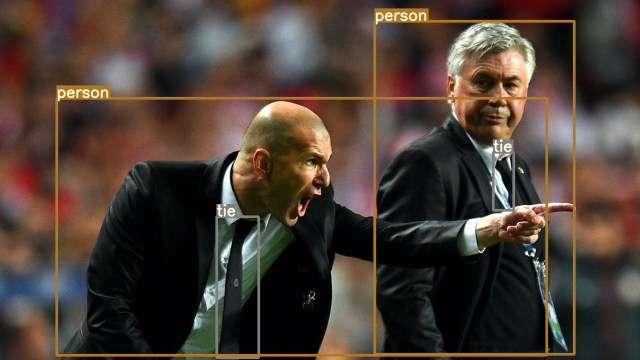

In [16]:
# Hah, that's the trick to rescale the box correctly
boxes = scale_coords(img.shape[1:], yolort_dets[0]['boxes'], img_raw.shape[:-1])

for box, label in zip(boxes.tolist(), yolort_dets[0]['labels'].tolist()):
    img_raw = plot_one_box(box, img_raw, color=COLORS[label % len(COLORS)], label=LABELS[label])

cv2_imshow(img_raw, imshow_scale=0.5)